# Mathematical Modelling for Sustainable Development
## Coursework Submission 2025
### Serena Farrelly

Question 1: Healthcare Resource Allocation Modelling

Modelling a queuing system to model arriving patients (walk ins and prearranged appointments) and the allocation of four clinicians. We want to assess the efficiency of the system and identify causes of delays.


### Modelling Assumptions

- a patient with an appointment arrives every 30 minutes

In [22]:
# Python Packages
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque # this is a new data type that is a 'double ended queue'

In [ ]:
# Simulation Functions

def Source_appt():
    # regular appointments through out the day
    # they arrive every 30 mins
    # a pretty hellish schedule lol
    return 30


def Source_walkin(mu_walkin):
    # random walkins
    return np.random.exponential(mu_walkin)



def Service_time(mu_service):
    # how long each appmnt takes
    return np.random.exponential(mu_service)

# Class defintions
class HealthCareService_c:
    def __init__(self, env, num_clinicians, mu_walkin, mu_service, lunch_rush):
        self.env = env
        self.num_clinicians = num_clinicians
        self.clinicians = simpy.Resource(self.env, num_clinicians)
        self.patients_list = [] # empty list to be filled with Patient_c class objects
        self.last_patient_type = 1
        self.next_walkin = 0

        self.num_in_system = 0                          # System begins empty - no one is in the system at t = 0
        self.clock = 0.0                                # Simulation begins at time t = 0
        self.t_arrival = self.generate_interarrival()   # Generate the first inter-arrival time based on the arrival rate (lambda) - generate_interarrival() is a user defined function below.
        self.t_depart = float('inf')                    # Set initial departure time to infinity, since there are initially no customers in the service             
        self.waits = []                                 # Creates a list to track waiting times for each customer
        self.total_wait = 0.0                           # Creares a variable for storing the total waiting time
        self.num_in_sys = [(0, 0)]                      # Track customers in the system with their arrival/departure times and the queue lengths
        self.queue = deque()                            # Initialises an empty queue to manage customer arrivals

        # tracking clinician up time
        self.usage_time = 0  # Total occupied time
        self.last_acquired = None  # Timestamp of last acquisition

        self.mu_rate = mu_walkin  # this stays constant 
        self.mu_walkin = mu_walkin #  mean walkin rate (mins) this gets updated
        self.mu_service = mu_service # mean service rate (mins)
        # self.duration = duration # simulation duration (mins)
        self.lunch_rush = lunch_rush # triggers lunch rush
    
    def define_param(self, mu_walkin, mu_service, lunch_rush, duration):
        self.mu_rate = mu_walkin  # this stays constant 
        self.mu_walkin = mu_walkin #  mean walkin rate (mins) this gets updated
        self.mu_service = mu_service # mean service rate (mins)
        self.duration = duration # simulation duration (mins)
        self.lunch_rush = lunch_rush # triggers lunch rush

    def clin_release(self, req):
        self.clinicians.release(req)
        if self.last_acquired is not None:
            self.usage_time += self.env.now - self.last_acquired  # Update occupied time
            self.last_acquired = None  # Reset

    def clin_log(self):
        self.last_acquired = self.env.now  # Log when resource is acquired
    
    def reset(self):
        self.num_patients_seen = 0
        self.num_in_sys = [(0,0)]
        self.patients_list = []

    # Method to handle the arrival of a customer
    def arrival(self):
        self.num_in_system += 1                         # Increase the number of customers in the system by 1
        # create new patient object
        
        self.queue.append(self.clock)                   # Add the current time to the queue (arrival time of the customer)
        self.in_systems.append((self.clock,len(self.queue)))

        ## COMMENT ON APPEND: Adds an element to the end of a list/array, e.g. 
        # X = [1, 2, 3]

        ## append '4' to the list
        # currencies.append([4])
        # print(X)
        ## Output: [1, 2, 3, 4]

        # Log the customer arrival, including the number of customers before and after
        print('%g: customer arrives (num_in_system=%d->%d)' % (self.t_arrival, self.num_in_system-1, self.num_in_system))

        # If the system was empty before the arrival, schedule a departure time for this customer - self.generate_service USER DEFINED function below
        if self.num_in_system <= self.num_clinicians:
            self.t_depart = self.clock + self.generate_service()

        # Generate the next inter-arrival time for the next customer - self.generate_interarrival USER DEFINED function below
        self.t_arrival = self.clock + self.generate_interarrival()

    def generate_interarrival(self):
        # vary patient arrival rate depending on simulation time
        if (self.env.now>=180 and self.env.now<=300 and self.lunch_rush):
            self.mu_walkin = self.mu_rate/2 # time in between arrivals is halved


        # Find out which is the next patient: walk in or appointment
        if (self.next_walkin==0 or self.last_patient_type == 2):
            # if this value is 0 (initialise) or the last patient was a walkin
            # generate a new talk in time
            self.next_walkin = Source_walkin(self.mu_walk)
        
        # compare which is the next patient: appointment or walkin
        if (self.next_walkin < Source_appt()):
            self.last_patient_type = 2
            next_patient_time = self.next_walkin
        else:
            self.last_patient_type = 1
            next_patient_time = Source_appt()

        self.t_arrival = next_patient_time

    def generate_service(self):
        Service_time(self.mu_service)
    
    # Method to handle the departure of a customer
    def departure(self):
        # Decrease the number of customers in the system
        self.num_in_system -= 1
        
        # Log the customer departure, including the number of customers before and after
        print('%g: customer departs (num_in_system=%d->%d)' % (self.t_depart, self.num_in_system+1, self.num_in_system))
        
        # Record the wait time for the departed customer by calculating the difference
        # between current time and the customer's arrival time (which is stored in the queue)
        t = self.queue.popleft()
        self.in_systems.append((self.clock, len(self.queue)))
        self.waits.append(self.clock - t)
        
        # If there are still customers in the system, schedule the next departure time
        if self.num_in_system > 0:
            self.t_depart = self.clock + self.generate_service()
        else:
            # If the system is empty, set the departure time to infinity
            self.t_depart = float('inf')

    # Method to advance the simulation time to the next event (either arrival or departure)
    def advance_time(self):
        # Determine the next event by selecting the earliest time (arrival or departure)
        t_event = min(self.t_arrival, self.t_depart)

        # Update the total wait time based on the number of customers currently in the system
        self.total_wait += self.num_in_system * (t_event - self.clock)
        self.clock = t_event  # Advance the clock to the time of the next event
        
        # If the next event is an arrival, process the arrival; otherwise, process the departure
        if self.t_arrival <= self.t_depart:
            self.arrival()
        else:
            self.departure()


class Patient_c:
    def __init__(self, id, type, entry_time):
        self.id = id
        self.type = type
        self.entry_time = entry_time
        self.wait_time = 0
        self.service_time = 0
        self.exit_time = 9999 # arbitrary high number. Gets updated when patient exits
    
    def __str__(self):
        return f"Patient:{self.id}(Type:{self.type}, Entry Time: {self.entry_time}, Exit Time: {self.entry_time})"
    

In [24]:
# Simulation function for the queuing system
def HealthCareService(env, HCS_obj, lunch_rush):
    next_patient_time = 0                                       # Intialise time variable to be minimised when the next patient time is determined
    last_patient_type = 1                                       # patient type: 1 = appointment, 2 = walkin
    next_walkin = 0

    mu_walkin = HCS_obj.mu_walkin
    while True:                                                 # In this case, while the simulation is running
        # creating a object in the Patient_c class and appending to patient list
        HCS_obj.num_patients += 1
        Patient_i = Patient_c(HCS_obj.num_patients,last_patient_type,0)
        
        # this is essentially a delay simulation until next patient arrival
        yield env.timeout(next_patient_time)

        # When the patient arrives, start a new patient process
        env.process(Patient(env, HCS_obj, Patient_i))

        # append serviced patient to patient list (all info stored within)
        HCS_obj.patients_list.insert(-1,Patient_i)

# patient process function to simulate each patient's interaction with the server
def Patient(env, HCS_obj, patient_obj):
    patient_obj.entry_time = env.now
    # Request a server from the pool of available servers
    # we are waiting for a clinician to be available
    with HCS_obj.clinicians.request() as request:
        # t_arrival = env.now  # Capture the arrival time of the patient

        # Track the number of patients currently in the system (both in service and in queue)
        HCS_obj.num_in_sys.append((patient_obj.entry_time, len(HCS_obj.clinicians.queue) + len(HCS_obj.clinicians.users)))
        # Log the patient arrival, including the number of patients 
        # print(f'{env.now}: patient {patient} arrives.  Current number of people in the system: {len(servers.queue) + len(servers.users)}')       

        # Yield until the patient gets service (i.e., waits for a server to be available)
        yield request

        HCS_obj.clin_log() # log if the patient has been picked up by a clinician

        # Generate and wait for the service time (time spent being served)
        patient_obj.service_time = Service_time(HCS_obj.mu_service)
        yield env.timeout(patient_obj.service_time)

        HCS_obj.clin_release(request) # log that the clinicians is now relieved of duty

        # patient departs after service
        patient_obj.exit_time = env.now  # Capture the departure time of the patient

        # Track the number of patients in the system after this patient departs
        HCS_obj.num_in_sys.append((patient_obj.exit_time, len(HCS_obj.clinicians.queue) + len(HCS_obj.clinicians.users)))

        # Log the patient departure, including the number of patients
        # print(f'{env.now}: patient {patient} departs. Current number of people in the system: {len(servers.queue) + len(servers.users) - 1}')

        # Record the wait time and service time for the patient
        patient_obj.wait_time = env.now - patient_obj.entry_time - patient_obj.service_time

        HCS_obj.num_patients_seen += 1




In [ ]:
# whether we want to model the lunch rush
lunch_rush = True

# Create parameter sweep
n_intvl = 10
arrival_rates = np.linspace(5,30,n_intvl) # i
service_rates = np.linspace(5,30,n_intvl) # j
sim_duration = 60*8
# print(arrival_rates)

# want to repeat to get confidence intervals
n_rep = 20 # r

simulation_results = np.empty((n_intvl, n_intvl, n_rep), dtype=object)

# loop to create simulation class objects
# for i in range(n_intvl):
#     for j in range(n_intvl):
#         for r in range(n_rep):
#             env = simpy.Environment()
#             #initialise simulation class object
#             HealthCareSim = HealthCareService_c(env, 4)
#             HealthCareSim.define_param(mu_walkin=arrival_rates[i], mu_service=service_rates[j],duration=sim_duration)

#             # clear data from last run
#             HealthCareSim.reset()

#             #run simulation
#             env.process(HealthCareService(HealthCareSim.env, HealthCareSim, lunch_rush))
#             env.run(until=HealthCareSim.duration)
#             # save all results
#             simulation_results[i, j, r] = HealthCareSim

for i in range(n_intvl):
    for j in range(n_intvl):
        for r in range(n_rep):
            env = simpy.Environment()
            #initialise simulation class object
            HealthCareSim = HealthCareService_c(env, 4)
            HealthCareSim.define_param(mu_walkin=arrival_rates[i], mu_service=service_rates[j], lunch_rush= lunch_rush, duration=sim_duration)

            # Run the simulation by advancing the time until the clock reaches the specified duration
            while HealthCareSim.clock < sim_duration:
                HealthCareSim.advance_time() 

            #run simulation
            env.process(HealthCareService(HealthCareSim.env, HealthCareSim, lunch_rush))
            env.run(until=HealthCareSim.duration)
            # save all results
            simulation_results[i, j, r] = HealthCareSim

# print(simulation_results[0:4,:,:])

AttributeError: 'HealthCareService_c' object has no attribute 'mu_walk'

### Yippee post processing

In [ ]:
# KPIs
# average wait time
# number of patients seen
# clinician up time
# number of patients wait > 60 mins

avg_wait = num_patients = clin_up = wait_60 = np.zeros((n_intvl, n_intvl, n_rep))

for i in range(n_intvl):
    for j in range(n_intvl):
        for r in range(n_rep):
            patient_waits = [patient.wait_time for patient in simulation_results[i, j, r].patients_list]
            avg_wait[i,j,r] = np.mean(patient_waits)
            wait_60[i,j,r] = sum(x > 60 for x in patient_waits)

            num_patients[i, j, r] = len(patient_waits)

            clin_up[i, j, r] = simulation_results[i, j, r].usage_time

### Plotting

In [ ]:
font_size = 22
tick_size = 16
label_padding = 25

(10, 10)
[[140.68973317 241.90021462 302.51029807 350.65783942 357.28589231
  397.93679735 412.07889571 431.0096941  431.88484791 447.95390664]
 [101.48299965 106.30043399 164.39493524 212.43275942 187.00109489
  292.87047147 329.17841455 345.79813074 370.96046284 366.68746624]
 [ 89.73368536 112.33605321 115.18883737 140.42870118 141.90657164
  131.40967037 168.86383746 164.36522208 183.18465757 233.76392784]]


/tmp/ipykernel_452334/22878450.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


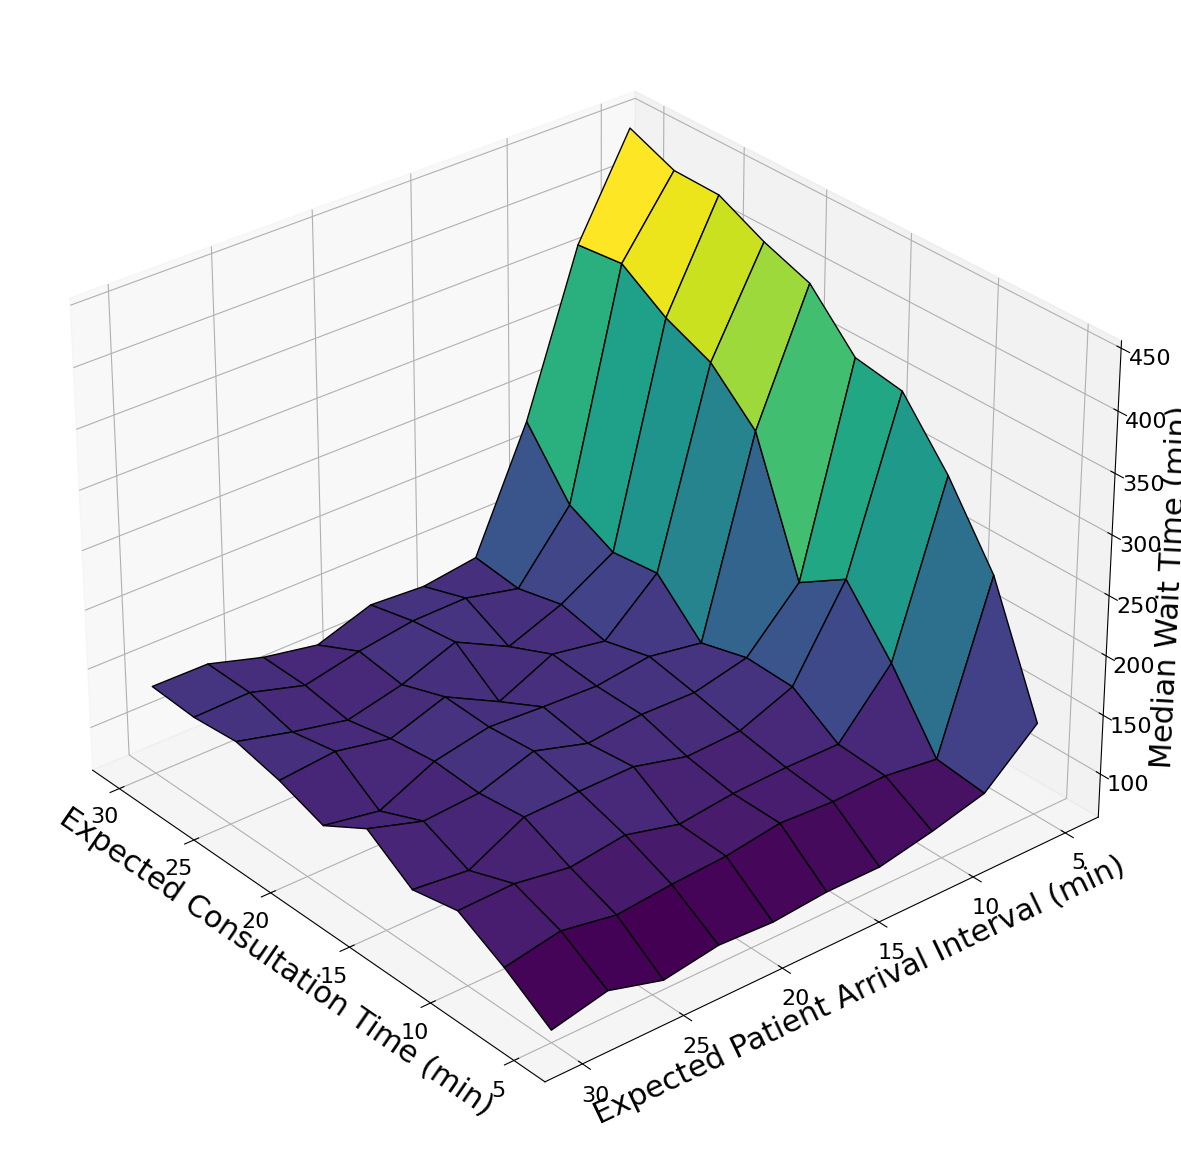

In [ ]:
# average wait time (surface plot)
X, Y = np.meshgrid(service_rates, arrival_rates)

median_avg_wait = np.median(avg_wait, axis=2)
print(np.shape(median_avg_wait))
print(median_avg_wait[0:3])

# Plot surface
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, median_avg_wait, cmap='viridis', edgecolor='k')
ax.view_init(elev=30, azim=140)
ax.dist = 50

ax.set_xlabel("Expected Consultation Time (min)", fontdict={'fontsize':font_size})
ax.set_ylabel("Expected Patient Arrival Interval (min)", fontdict={'fontsize':font_size})
ax.set_zlabel("Median Wait Time (min)", fontdict={'fontsize':font_size})

# ax.xaxis.labelpad = label_padding  
# ax.yaxis.labelpad = label_padding  
# ax.zaxis.labelpad = label_padding

pos = ax.get_position()  # Get current plot position
ax.set_position([pos.x0 - 1, pos.y0, pos.width, pos.height])  # Shift left


ax.tick_params(axis="both", labelsize=tick_size)

plt.tight_layout()
plt.subplots_adjust(left=0.005, right=0.95) 
plt.show()


[[140.68973317 241.90021462 302.51029807 350.65783942 357.28589231
  397.93679735 412.07889571 431.0096941  431.88484791 447.95390664]
 [101.48299965 106.30043399 164.39493524 212.43275942 187.00109489
  292.87047147 329.17841455 345.79813074 370.96046284 366.68746624]
 [ 89.73368536 112.33605321 115.18883737 140.42870118 141.90657164
  131.40967037 168.86383746 164.36522208 183.18465757 233.76392784]]


/tmp/ipykernel_452334/1019840802.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


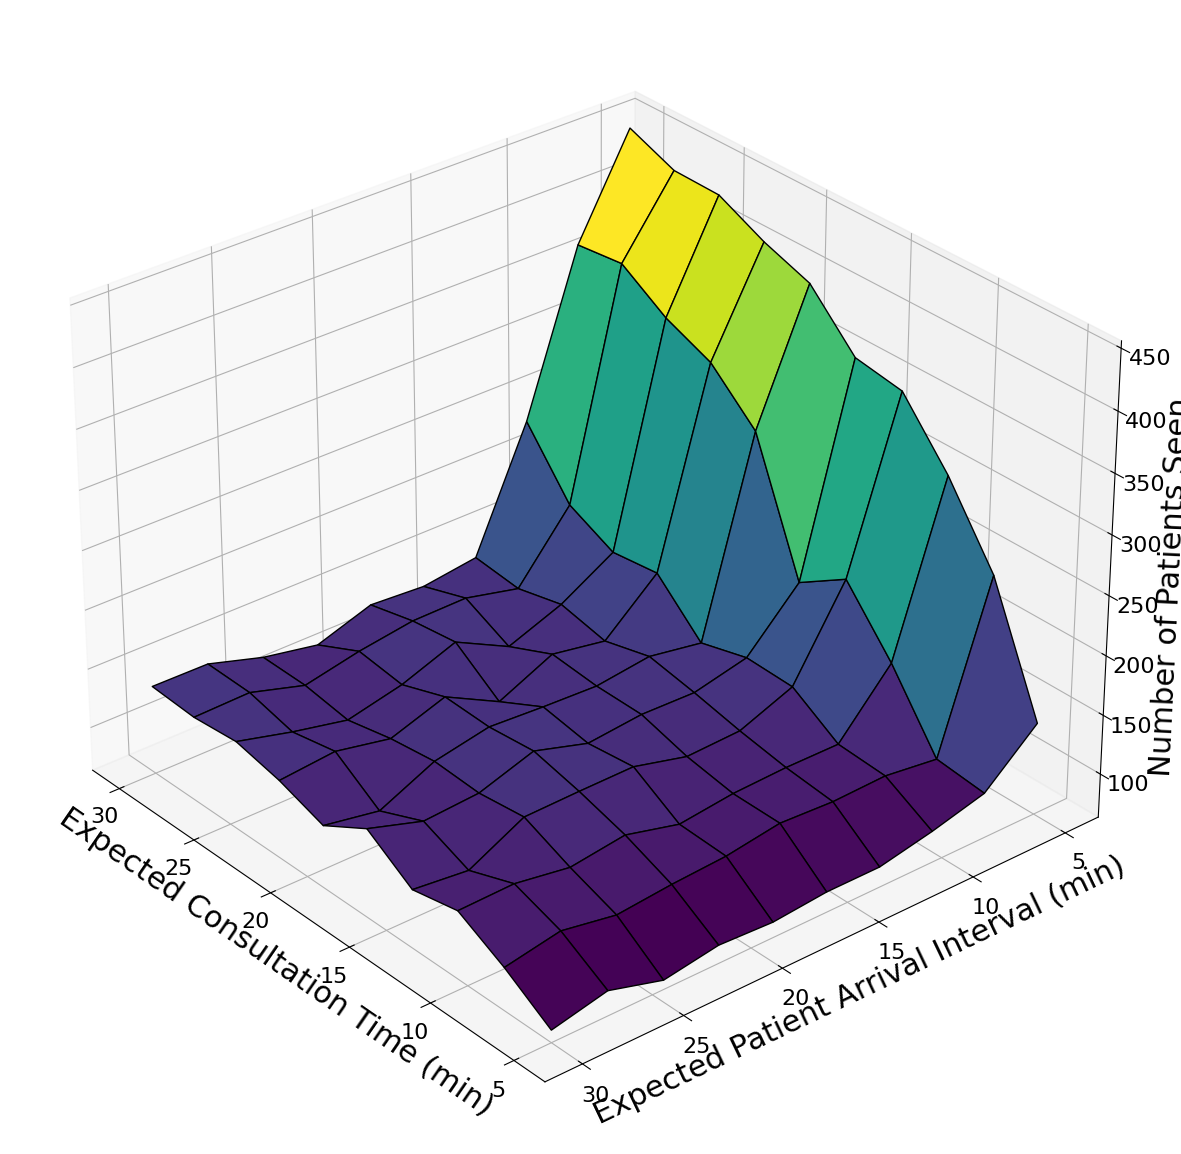

In [ ]:
# average wait time (surface plot)
X, Y = np.meshgrid(service_rates, arrival_rates)

median_num_patients = np.median(num_patients, axis=2)
print(median_num_patients[0:3])

# Plot surface
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, median_num_patients, cmap='viridis', edgecolor='k')
ax.view_init(elev=30, azim=140)
ax.dist = 50

ax.set_xlabel("Expected Consultation Time (min)", fontdict={'fontsize':font_size})
ax.set_ylabel("Expected Patient Arrival Interval (min)", fontdict={'fontsize':font_size})
ax.set_zlabel("Number of Patients Seen", fontdict={'fontsize':font_size})

# ax.xaxis.labelpad = label_padding  
# ax.yaxis.labelpad = label_padding  
# ax.zaxis.labelpad = label_padding

pos = ax.get_position()  # Get current plot position
ax.set_position([pos.x0 - 1, pos.y0, pos.width, pos.height])  # Shift left


ax.tick_params(axis="both", labelsize=tick_size)

plt.tight_layout()
plt.subplots_adjust(left=0.005, right=0.95) 
plt.show()


In [ ]:
# average wait time (surface plot)
X, Y = np.meshgrid(service_rates, arrival_rates)

median_clin_up = (np.median(clin_up, axis=2)/sim_duration)*100

# Plot surface
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, median_clin_up, cmap='viridis', edgecolor='k')
ax.view_init(elev=30, azim=140)
ax.dist = 50

ax.set_xlabel("Expected Consultation Time (min)", fontdict={'fontsize':font_size})
ax.set_ylabel("Expected Patient Arrival Interval (min)", fontdict={'fontsize':font_size})
ax.set_zlabel("Percentage of day Clinicians are in Consultation (%)", fontdict={'fontsize':font_size})

# ax.xaxis.labelpad = label_padding  
# ax.yaxis.labelpad = label_padding  
# ax.zaxis.labelpad = label_padding

pos = ax.get_position()  # Get current plot position
ax.set_position([pos.x0 - 1, pos.y0, pos.width, pos.height])  # Shift left


ax.tick_params(axis="both", labelsize=tick_size)

plt.tight_layout()
plt.subplots_adjust(left=0.005, right=0.95) 
plt.show()


NameError: name 'clin_up' is not defined